在二分问题内
数据集和模型
我们将使用线性 SVC 分类器来区分两种类型的鸢尾花。

In [18]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)

# 加入噪声特征
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

# 限制为前两个类别，然后拆分训练集跟测试集
X_train, X_test, y_train, y_test = train_test_split(
    X[y < 2], y[y < 2], test_size=0.5, random_state=random_state
)



In [19]:
print(X)

[[ 5.1         3.5         1.4        ... -1.07709907 -0.4246633
  -0.8299646 ]
 [ 4.9         3.          1.4        ...  1.4121517  -1.38043075
  -0.53591456]
 [ 4.7         3.2         1.3        ...  0.65880214 -0.59691711
  -0.22295918]
 ...
 [ 6.5         3.          5.2        ... -0.5154906  -0.12964864
  -0.5092809 ]
 [ 6.2         3.4         5.4        ...  1.42147798 -0.61336209
  -0.34432031]
 [ 5.9         3.          5.1        ...  2.53170549 -0.03572203
   0.17320019]]


In [20]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [21]:
print(random_state)

RandomState(MT19937)


In [22]:
X_train

array([[ 4.6       ,  3.6       ,  1.        , ...,  0.06881887,
         0.73902653,  0.26106667],
       [ 5.1       ,  3.8       ,  1.5       , ...,  1.41938754,
         0.74710667, -0.10630249],
       [ 5.5       ,  3.5       ,  1.3       , ...,  1.1038747 ,
         0.04572089, -0.31955085],
       ...,
       [ 5.5       ,  2.5       ,  4.        , ..., -1.55673663,
         0.14321934, -1.24624422],
       [ 6.7       ,  3.        ,  5.        , ..., -0.20144195,
        -2.03835412,  0.76707069],
       [ 6.3       ,  2.3       ,  4.4       , ...,  1.38353355,
         0.71427849, -0.28417349]])

线性 SVC 期望每个特征具有相似的值范围。因此，我们将首先使用 StandardScaler 缩放数据。

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

classifier = make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
classifier.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(random_state=RandomState(MT19937) at 0x7FB840F1E840))])

绘制 准确率-召回率 曲线
要绘制 准确率-召回率 曲线，您应该使用 PrecisionRecallDisplay。实际上，有两种方法可用，具体取决于您是否已经计算了分类器的预测。

让我们首先绘制没有分类器预测的 准确率-召回率 曲线。我们使用 from_estimator 在绘制曲线之前为我们计算预测。

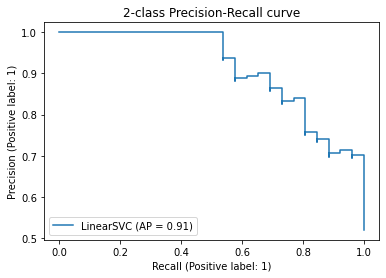

In [24]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


如果我们已经获得了模型的估计概率或分数，那么我们可以使用 from_predictions。

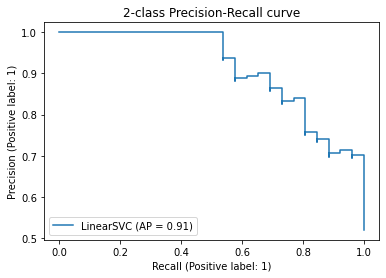

In [5]:
y_score = classifier.decision_function(X_test)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")


译者注：
其实第一个就是把训练好的模型直接扔进去让他们帮我们把测试集算分，
第二个是把分数算好直接绘制。

在输出结果为多标签模型中
准确率-召回率 曲线不支持结果为多标签（多分类）模型。但是，人们可以决定如何处理这种情况。我们在下面展示了这样一个例子。

创建多标签数据、拟合和预测
我们创建了一个多标签数据集，以说明多标签模型中的准确率-召回率。

In [6]:
from sklearn.preprocessing import label_binarize

# 使用 label_binarize 进行多标签设置
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# 分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=random_state
)


我们使用 OneVsRestClassifier 进行多标签预测。

In [8]:
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)


多标签模型中的平均准确率分数

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# 对应每个分类（标签）
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# "micro-average"（微平均）: 联合量化所有分类（标签）的分数
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")


绘制 微平均 （micro-average） 准确率-召回率 曲线

绘制每个类别的 准确率-召回率 曲线和 iso-f1 曲线

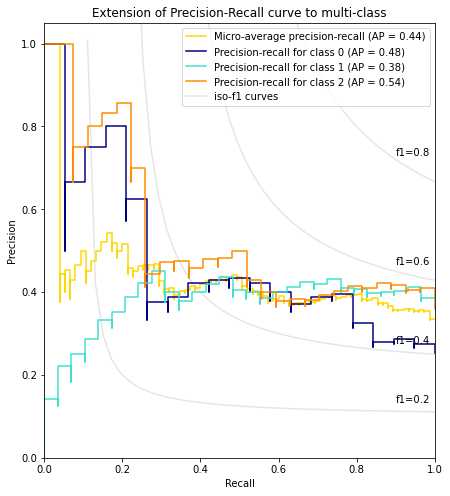

In [10]:
import matplotlib.pyplot as plt
from itertools import cycle

# 设置绘图细节
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# 加入 iso-f1 曲线的图例
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# 设置图例与坐标轴
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

